## Notebook for testing performance of intent classification in Watson Assistant Service
[IBM Watson’s AI](http://www.ibm.com/watson/products-services) capabilities organized into 6 categories and available as API’s on IBM Cloud. These platform is AI services that leverage machine learning techniques help clients solve a variety business problems. Furthermore, several of the AI API's/ services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your Watson Assistant service based solution.

- Based on code by Joe Kozhaya https://github.com/joe4k/wdcutils

<br> The notebook assumes you have already created a [Watson Assistant Service](https://www.ibm.com/watson/ai-assistant/) instance and trained it based on a number of intents. </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your Watson Assistant instance (username and password)
* Workspace ID for your Watson Assistant instance 
* CSV file with your text utterances and corresponding intent labels
* Results CSV file to write the results to
* CSV file to write confusion matrix results to

### Install and Import the Packages

In [1]:
# YOU CAN COMMENT THE FOLLOWING 2 COMMANDS IF YOU ALREADY HAVE THE PACKAGES INSTALLED

# Only run this cell if you don't have pandas_ml or watson_developer_cloud installed
!pip install pandas_ml

# Install the Watson Developer Cloud Python SDK. This is a one time activity.
!pip install --upgrade watson-developer-cloud

    100% |████████████████████████████████| 256kB 3.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for watson-developer-cloud ... done
  Stored in directory: /Users/swamchan/Library/Caches/pip/wheels/2c/1a/d9/0dfd4f0c4114803dc2028952471685e664fe612dde51bc1a7e
Successfully built watson-developer-cloud
  Found existing installation: watson-developer-cloud 2.2.6
    Uninstalling watson-developer-cloud-2.2.6:
      Successfully uninstalled watson-developer-cloud-2.2.6


In [2]:
#Import utilities
import json
import sys
import codecs
import unicodecsv as csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas_ml
from pandas_ml import ConfusionMatrix
from watson_developer_cloud import AssistantV1

### Provide required parameters 
Provide the credentials to access your Assistant service instance as well as the model test CSV file.
Also provide the path & name where the output as well as the confusion matrix results CSV files have to be written.

In [3]:
# Params data. Privide your specific information
url = "https://gateway.watsonplatform.net/assistant/api"

#Watson Assistant Instance username
user = ""

#Watson Assistant Instance password
password = ""

# Watson Assistant WORKSPACE_ID
workspace_id = "a8d8c4b7-d784-4b6f-a1c4-a1886852f16a"

#NOTE: The test data CSV file should have 2 columns {text, class} with appropriate values. No header.
# text column being the test utterance
# class column being the expected intent class
test_csv_file = "/Users/swamchan/Documents/Packt-Watson/Part-I/Section3/data/model_test.csv"
results_csv_file = "/Users/swamchan/Documents/Packt-Watson/Part-I/Section3/data/model_results.csv"
confmatrix_csv_file = "/Users/swamchan/Documents/Packt-Watson/Part-I/Section3/data/model_cmtx.csv"

### Create an object for your Watson Assistant instance

In [4]:
# Make sure to update the version to match your Assistant workspace
conversation = AssistantV1(
  username=user,
  password=password,
  version='2018-09-20')

### Define useful methods to classify using trained Watson Assistant service.

In [5]:
# Given a text string and a pointer to Assistant instance and workspaceID, get back Assistant response
def getConversationResponse(conv_instance, workspaceID, string):
    context={}
    # remove newlines from input text as that causes Assistant to return an error
    string = string.replace("\n","")
    response = conv_instance.message(
        workspace_id=workspaceID, 
        input={'text':string},
        context=context)
    classes=response
    return classes

# Process multiple text utterances (provided via csv file) in batch. Effectively, read the CSV file and for each text
# utterance, get Assistant response. Aggregate and return results.
def batchConversation(conv_instance, workspaceID, csvfile):
    test_classes=[]
    convpredict_classes=[]
    convpredict_confidence=[]
    text=[]
    i=0
    print('Reading CSV file: ', csvfile)
    with open(csvfile,"rb") as csvfile:
        # For better handling of utf8 encoded text
        csvReader = csv.reader(csvfile, encoding="utf-8-sig")
        for row in csvReader:
            # Assume input text is 2 column csv file, first column is text
            # and second column is the label/class/intent
            # Sometimes, the text string includes commas which may split
            # the text across multiple colmns. The following code handles that.
            if len(row) > 2:
                qelements = row[0:len(row)-1]
                utterance = ",".join(qelements)
                test_classes.append(row[len(row)-1])
            else:
                utterance = row[0]
                test_classes.append(row[1])
            utterance = utterance.replace('\r', ' ')
            print ('i: ', i, ' testing row: ', utterance)
          
            conv_response = getConversationResponse(conv_instance,workspaceID,utterance)
            #print(conv_response)
            
            if conv_response.result['intents']: 
                convpredict_classes.append(conv_response.result['intents'][0]['intent'])
                convpredict_confidence.append(conv_response.result['intents'][0]['confidence'])
            else:
                convpredict_classes.append('')
                convpredict_confidence.append(0)
            text.append(utterance)
            i = i+1
            if(i%250 == 0):
                print("")
                print('Processed ', i, ' records')
            if(i%10 == 0):
                sys.stdout.write('.'),
        print("")
        print ('Finished processing ', i, ' records')
    return test_classes, convpredict_classes, convpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix, labels, csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

### Call Assistant using the specified test CSV file and collect results.

In [6]:
test_classes,convpredict_classes,convpredict_conf,text=batchConversation(conversation, workspace_id, test_csv_file)

Reading CSV file:  /Users/swamchan/Documents/Packt-Watson/Part-I/Section3/data/model_test.csv
i:  0  testing row:  How do I change my Stack Exchange password?
i:  1  testing row:  Can't seem to find the option to reset my password
i:  2  testing row:  How do you reset a Windows 10 password?
i:  3  testing row:  Need help fixing paper jam
i:  4  testing row:  Printing issue in bluetooth printer
i:  5  testing row:  Install fails on FreeBSD 12.0
i:  6  testing row:  AWS S3 charging for 4 TB of storage when only using less than 1 GB
i:  7  testing row:  Bye bye my friend
i:  8  testing row:  Hi. Nice to meet you

Finished processing  9  records


### Write results to a CSV file

In [7]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by Assistant.
csvfileOut=results_csv_file
csvWriter = codecs.open(csvfileOut, 'w', encoding="utf-8-sig")

outrow=['text','true class','Assistant Predicted class','Confidence']
csvWriter.write("text" + "," + "true class" + "," + "Assistant Predicted class" + "," + "Confidence")
csvWriter.write("\n")

for i in range(len(text)):
    t = text[i]
    txt = text[i]
    if txt[:1] != '"' or txt.strip()[-1] != '"':
        txt = "\"" + txt + "\""
    csvWriter.write(txt + "," + test_classes[i] + "," + convpredict_classes[i] + "," + str(convpredict_conf[i]))
    csvWriter.write("\n")
csvWriter.close()

### Compute confusion matrix

In [8]:
# Compute confusion matrix
labels=list(set(test_classes))
conv_confusion_matrix = confusion_matrix(test_classes, convpredict_classes, labels)
convConfMatrix = ConfusionMatrix(test_classes, convpredict_classes)

### Write confusion matrix to a CSV file

In [9]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(conv_confusion_matrix,labels,confmatrix_csv_file)

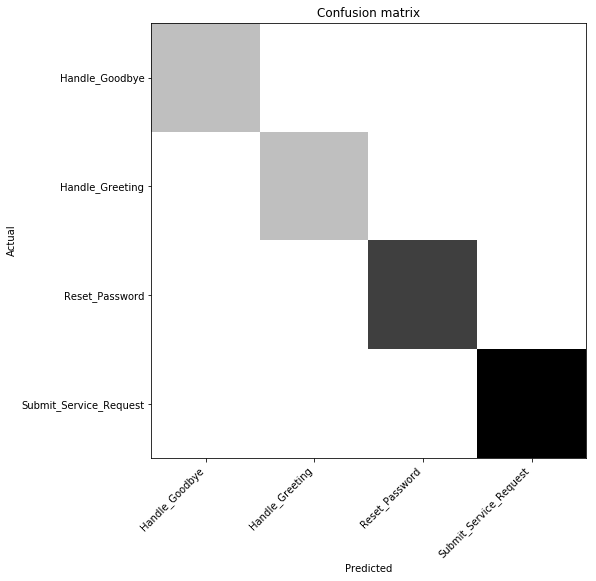

In [10]:
%matplotlib inline
convConfMatrix.plot()

### Plat confusion matrix

In [11]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, convpredict_classes)
print ('Classification Accuracy: ', acc)

Classification Accuracy:  1.0


### Print precision, recall and F1-scores for the different classes

In [12]:
print(classification_report(test_classes, convpredict_classes, labels=labels))

                        precision    recall  f1-score   support

        Reset_Password       1.00      1.00      1.00         3
Submit_Service_Request       1.00      1.00      1.00         4
        Handle_Goodbye       1.00      1.00      1.00         1
       Handle_Greeting       1.00      1.00      1.00         1

           avg / total       1.00      1.00      1.00         9

